In [1]:
import pickle
import cv2
import numpy as np

# perform camera calibration
def cam_cal(images, nx, ny):
    
    # Arrays to store object points and image points from all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane
    
    
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ...., (7,5,0)
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) #x, y coordinates
    
    # Go through all images
    for img in images:
        im = cv2.imread(img)

        # Convert image to grayscale
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    # Using cv2.calibrateCamera()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    
    return mtx, dist

In [2]:
def plt2img(img1, img2, cmap1='viridis', cmap2='viridis'):
    #plt.imshow(img1)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    
    # Image 1
    ax1.imshow(img1, cmap=cmap1)
    ax1.set_title('Image 1', fontsize=50)
    
    # Image 2
    ax2.imshow(img2, cmap=cmap2)
    ax2.set_title('Image 2', fontsize=50)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

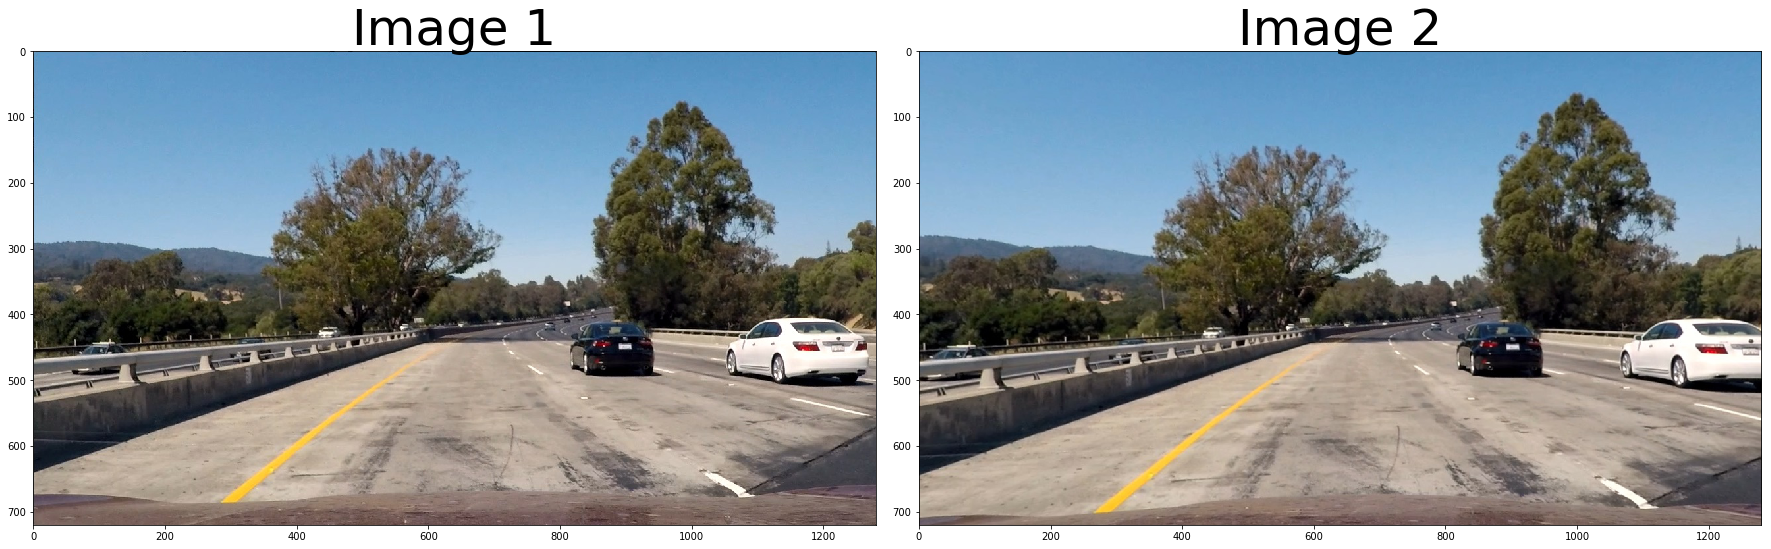

In [16]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Read in an image
images = glob.glob('./camera_cal/calibration*.jpg')

# Calibrate camera
mtx, dist = cam_cal(images, nx = 9, ny = 6)

# Load test image
img =  mpimg.imread('./test_images/test1.jpg')

# Undistort image
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Plot result
plt2img(img, undist)

In [3]:
def binary_transform(img, s_thresh=(120, 255), sx_thresh=(50, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary =  np.uint8(np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255)
    return combined_binary
    

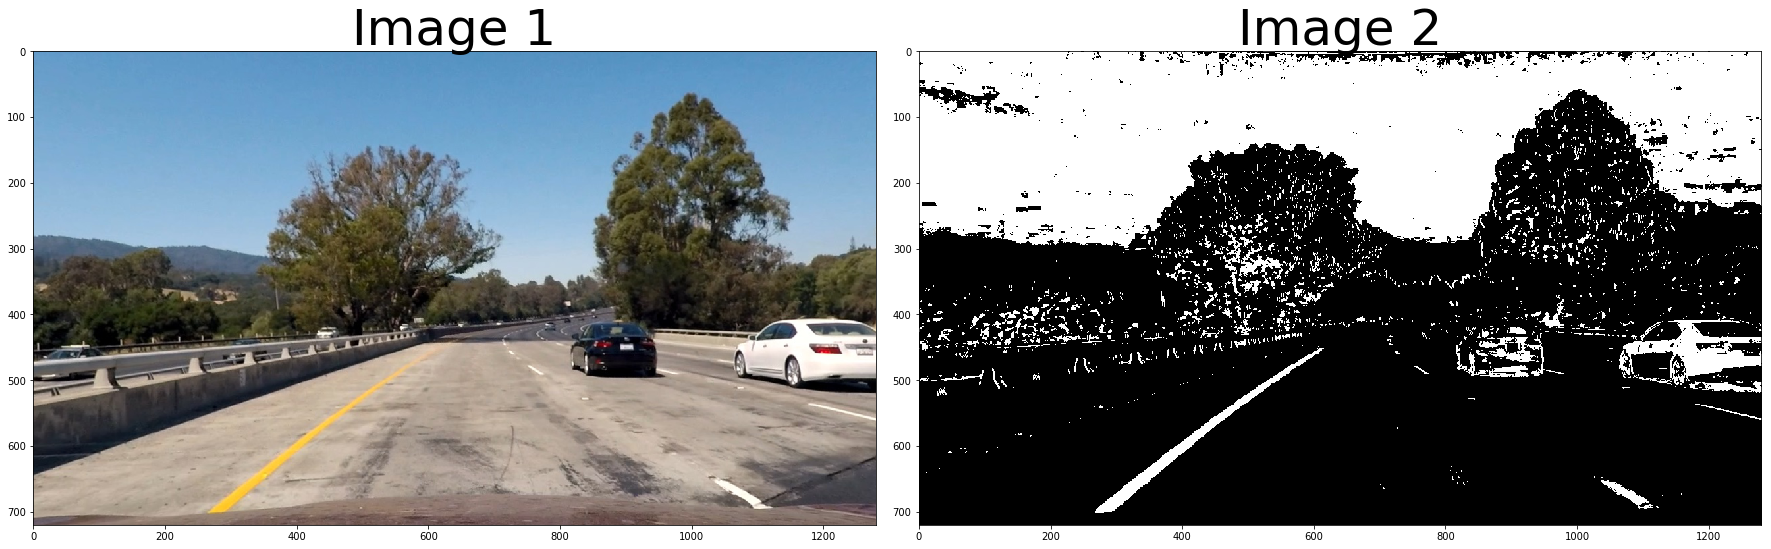

In [19]:
undist_binary = binary_transform(undist)
plt2img(undist, undist_binary, cmap2='gray')

In [4]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])  # Image size
    bot_width = .76  # percent of bottom trapizoid height
    mid_width = .1  # percent of middle trapizoid height
    height_pct = .62  # percent for trapizoid height
    bottom_trim = 0.935 # percent from top to bottom to avoid car hood
    
    src = np.float32([[img_size[0]*(.5-mid_width/2), img_size[1]*height_pct],
                     [img_size[0]*(.5+mid_width/2), img_size[1]*height_pct],
                     [img_size[0]*(.5+bot_width/2), img_size[1]*bottom_trim],
                     [img_size[0]*(.5-bot_width/2), img_size[1]*bottom_trim]])
    
    offset = img_size[0]*.15
    dst = np.float32([[offset,0],
                      [img_size[0]-offset,0],
                      [img_size[0]-offset,img_size[1]],
                      [offset,img_size[1]]])
    
    # Use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(np.asarray(src), np.asarray(dst))
    
    # Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)

    return warped, M, Minv



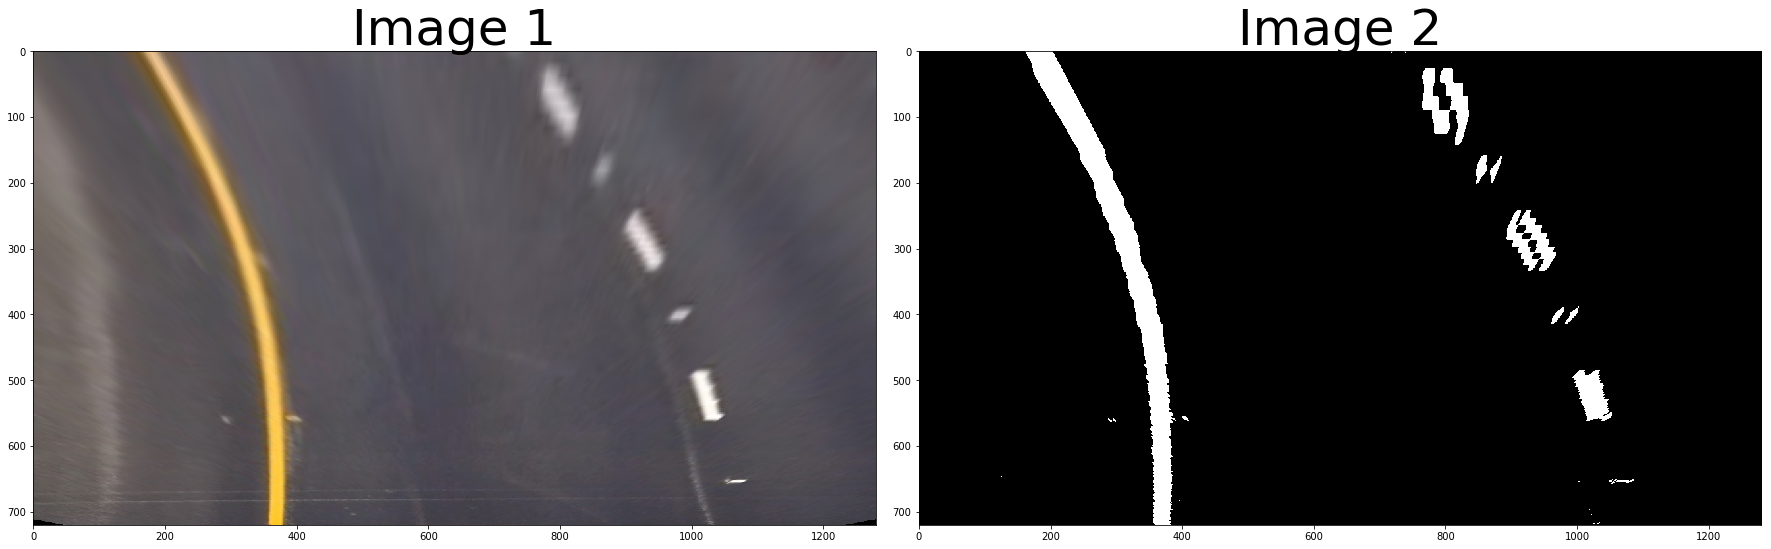

In [76]:
top_down, perspective_M, Minv = warp(undist)
top_down_binary, perspective_M, Minv_binary = warp(undist_binary)

plt2img(top_down, top_down_binary, cmap2='gray')

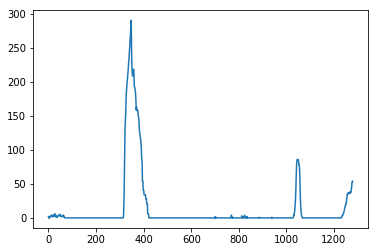

In [22]:
histogram = np.sum(top_down_binary[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

In [78]:
#warped = binary_warped
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids



def window_centroids_result(window_centroids, warped):

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
     
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    return output


(720, 1280, 3)


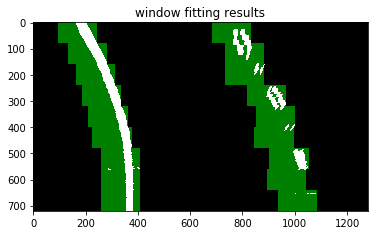

In [79]:
window_centroids = find_window_centroids(top_down_binary, window_width, window_height, margin)
centroids_results = window_centroids_result(window_centroids, top_down_binary)

print(centroids_results.shape)

# Display the final results
plt.imshow(centroids_results)
plt.title('window fitting results')
plt.show()

In [109]:
X_left = [window_centroid[0] for window_centroid in window_centroids]
X_right = [window_centroid[1] for window_centroid in window_centroids]
print(X_left)
print(X_right)
    


[374.0, 364.0, 363.0, 352.0, 335.0, 309.0, 280.0, 244.0, 199.0]
[1033.0, 1018.0, 1020.0, 971.0, 949.0, 926.0, 859.0, 806.0, 790.0]


1137.81444274 1317.0783083
371.974543034 m 422.533074555 m


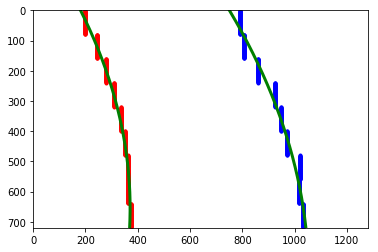

In [110]:
image = centroids_results
#y_eval = image.shape[0]


# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
#quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
for i in range(0,9):   
    #for j in range(0, 659):
        leftx[i*80:(i+1)*80] = X_left[i]
        rightx[i*80:(i+1)*80] = X_right[i]

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images


#-----

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

#---


# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

plt.show()

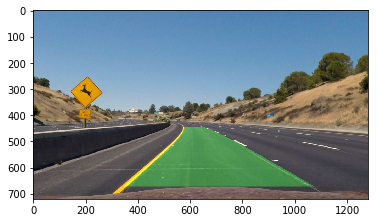

In [111]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.show()

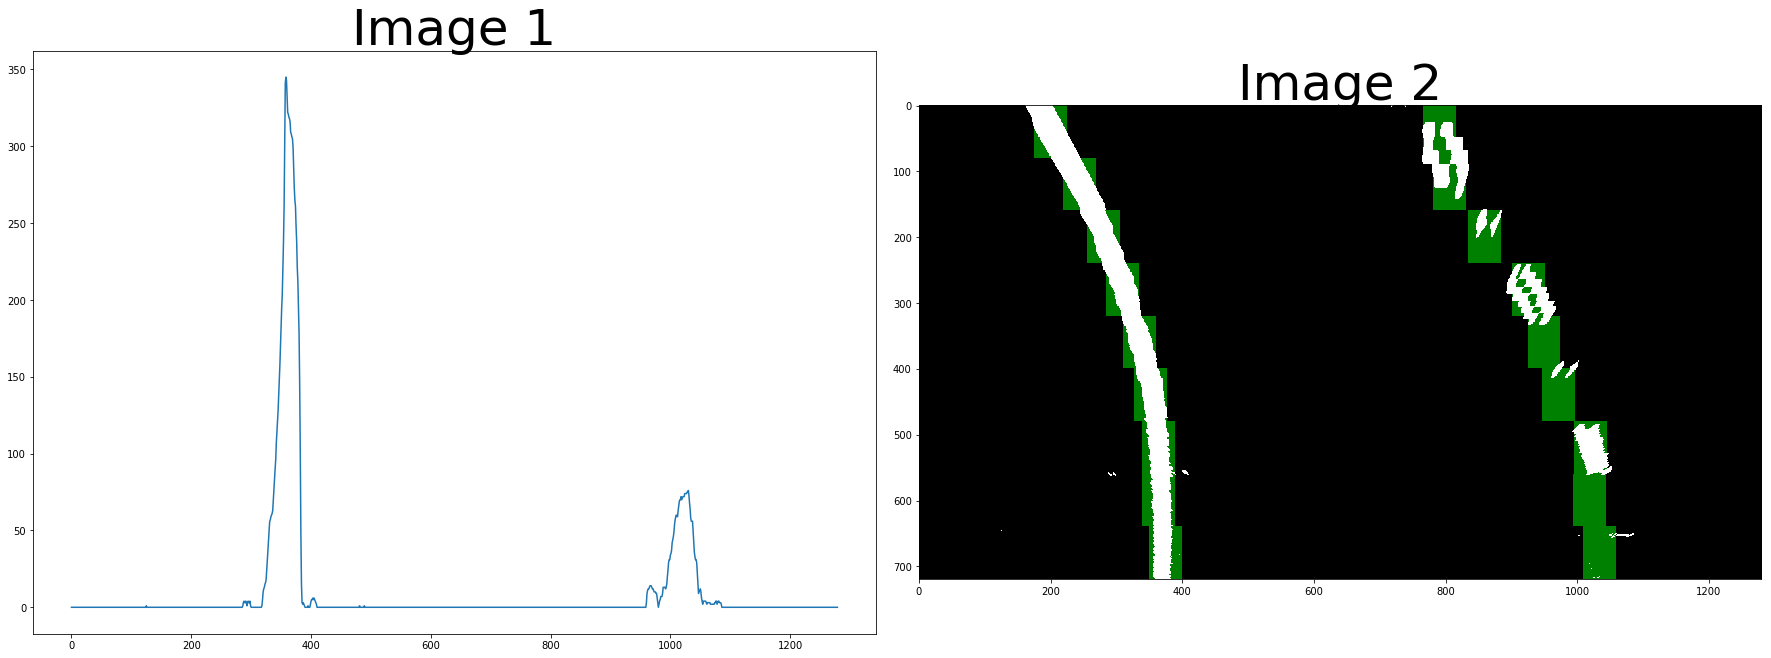

In [108]:
import pickle
import cv2
import numpy as np

import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Read in an image
images = glob.glob('./camera_cal/calibration*.jpg')

# Calibrate camera
mtx, dist = cam_cal(images, nx = 9, ny = 6)

# Load test image
img =  mpimg.imread('./test_images/test2.jpg')

# Undistort image
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Generate binary image
undist_binary = binary_transform(undist)


# Warp image to change perspective
warped, perspective_M, Minv = warp(undist)
warped_binary, perspective_M, Minv_binary = warp(undist_binary)



# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

window_centroids = find_window_centroids(warped_binary, window_width, window_height, margin)

centroids_results = window_centroids_result(window_centroids, warped_binary)


histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)

# Plot result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

# Image 1
ax1.plot(histogram)
ax1.set_title('Image 1', fontsize=50)

# Image 2
ax2.imshow(centroids_results)
ax2.set_title('Image 2', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
